The loose plan: correlate several geological datasets over several environmental parameters (chemical composition of soil, temperature, humidity, rainfall, anything else that we can expect to CHANGE over the next few decades). Then perform some clustering (K-means), and finally make some projections about the future of climate using a Gaussian process.

We can also try to identify which parameters are most critical to growth for given crops. We can categorize the parameters as "macro" (temperature, rainfall, humidity) and "micro" (pH, nitrogen, etc).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

c:\Users\mlisi\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Part 1: Crops!

Our first dataset contains information on the levels of nitrogen, phosphorus, and potassium in soil (kg/ha), as well as temperature, humidity, pH, and rainfall.

In [2]:
crop_rec_df = pd.read_csv('data/Crop_recommendation.csv')
crop_rec_df = crop_rec_df.drop(columns=["Unnamed: 8", "Unnamed: 9"])
crop_rec_df.head()

,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


These are the different crops we will be working with.

In [3]:
crops = crop_rec_df.label.unique()
crops

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [5]:
nitrogens = []
phosphori = []
potassiums = []
temperatures = []
humidities = []
phs = []
rainfalls = []

for crop in crops:
    
    # Calculate the average values for each crop
    avg_nitrogen = crop_rec_df[crop_rec_df['label'] == crop]['Nitrogen'].mean()
    avg_phosphorus = crop_rec_df[crop_rec_df['label'] == crop]['phosphorus'].mean()
    avg_potassium = crop_rec_df[crop_rec_df['label'] == crop]['potassium'].mean()
    avg_temp = crop_rec_df[crop_rec_df['label'] == crop]['temperature'].mean()
    avg_humidity = crop_rec_df[crop_rec_df['label'] == crop]['humidity'].mean()
    avg_ph = crop_rec_df[crop_rec_df['label'] == crop]['ph'].mean()
    avg_rainfall = crop_rec_df[crop_rec_df['label'] == crop]['rainfall'].mean()
    
    # Aggregate
    nitrogens.append(avg_nitrogen)
    phosphori.append(avg_phosphorus)
    potassiums.append(avg_potassium)
    temperatures.append(avg_temp)
    humidities.append(avg_humidity)
    phs.append(avg_ph)
    rainfalls.append(avg_rainfall)

d = {"crop": crops,
     "nitrogen": nitrogens,
     "phosphorus": phosphori,
     "potassium": potassiums,
     "temperature": temperatures,
     "humidity": humidities,
     "ph": phs,
     "rainfall": rainfalls
     }

avg_crop_data_df = pd.DataFrame(d)
avg_crop_data_df

,crop,nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall
0,rice,79.89,47.58,39.87,23.689332,82.272822,6.425471,236.181114
1,maize,77.76,48.44,19.79,22.389204,65.092249,6.245190,84.766988
2,chickpea,40.09,67.79,79.92,18.872847,16.860439,7.336957,80.058977
3,kidneybeans,20.75,67.54,20.05,20.115085,21.605357,5.749411,105.919778
4,pigeonpeas,20.73,67.73,20.29,27.741762,48.061633,5.794175,149.457564
5,mothbeans,21.44,48.01,20.23,28.194920,53.160418,6.831174,51.198487
6,mungbean,20.99,47.28,19.87,28.525775,85.499975,6.723957,48.403601
7,blackgram,40.02,67.47,19.24,29.973340,65.118426,7.133952,67.884151
8,lentil,18.77,68.36,19.41,24.509052,64.804785,6.927932,45.680454
9,pomegranate,18.87,18.75,40.21,21.837842,90.125504,6.429172,107.528442


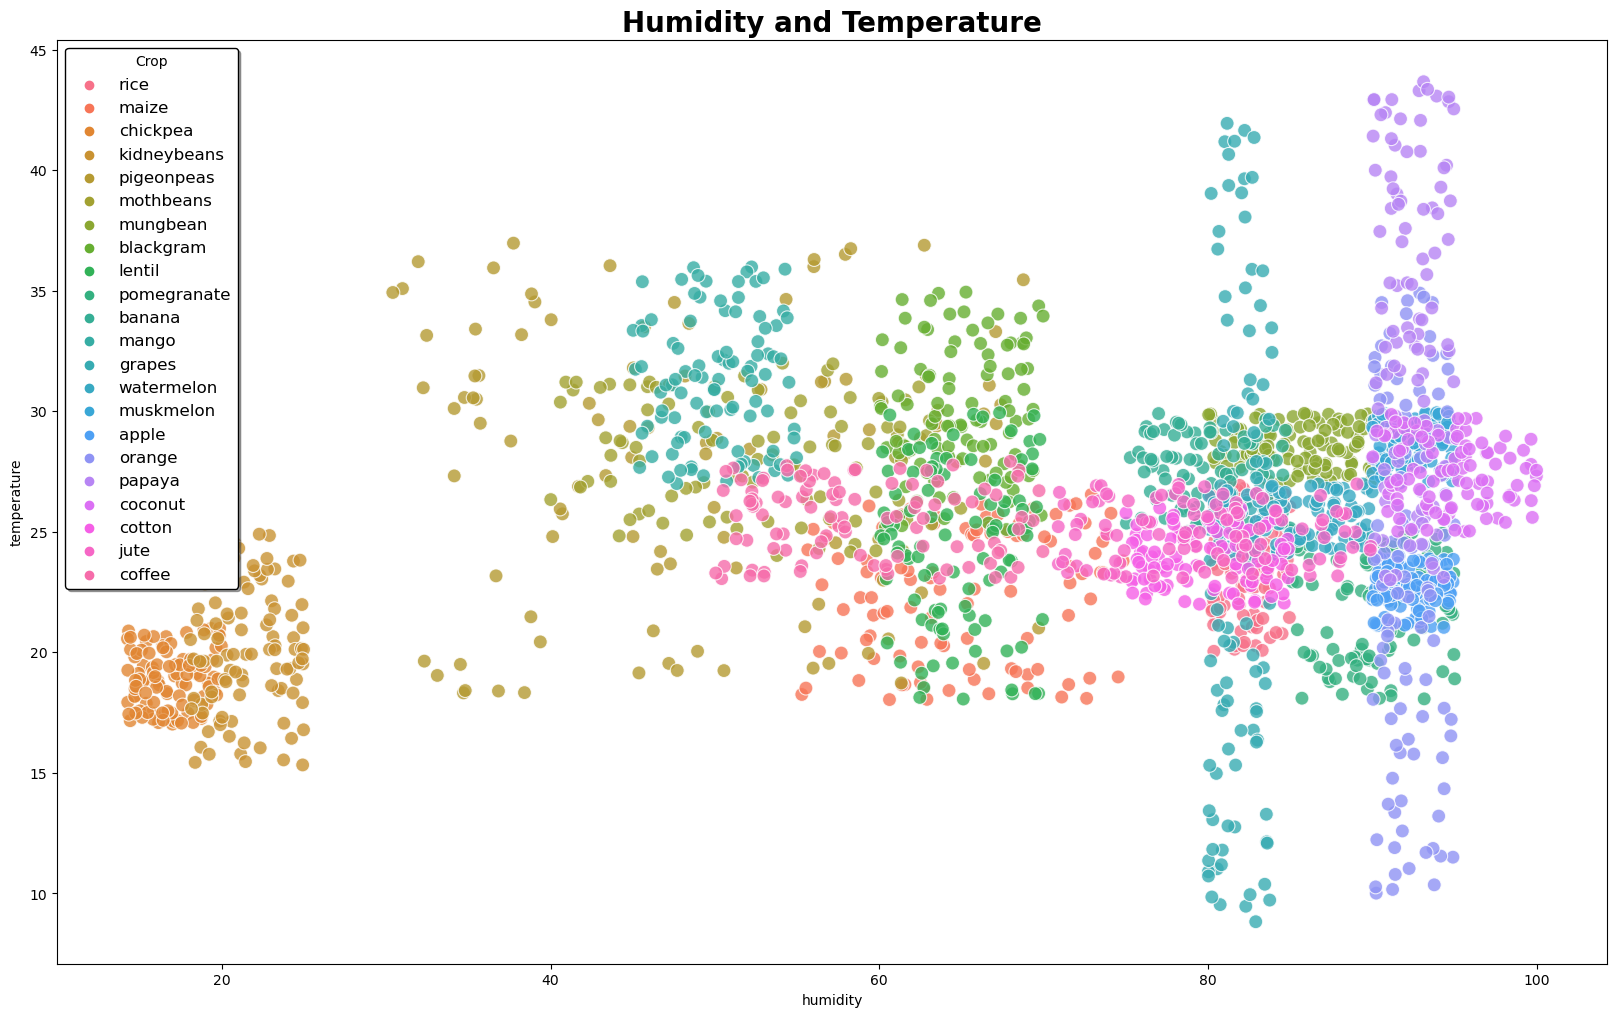

In [6]:
fig, ax = plt.subplots(figsize=(20, 12))

sns.scatterplot(x = "humidity", y = "temperature", hue = "label", data = crop_rec_df, s = 100, alpha = 0.8)
ax.set_title("Humidity and Temperature", fontsize=20, fontweight = 'bold')
ax.legend(title = "Crop", fontsize = 12, loc = 'upper left', frameon = True, edgecolor = 'black', shadow = True)

plt.show()

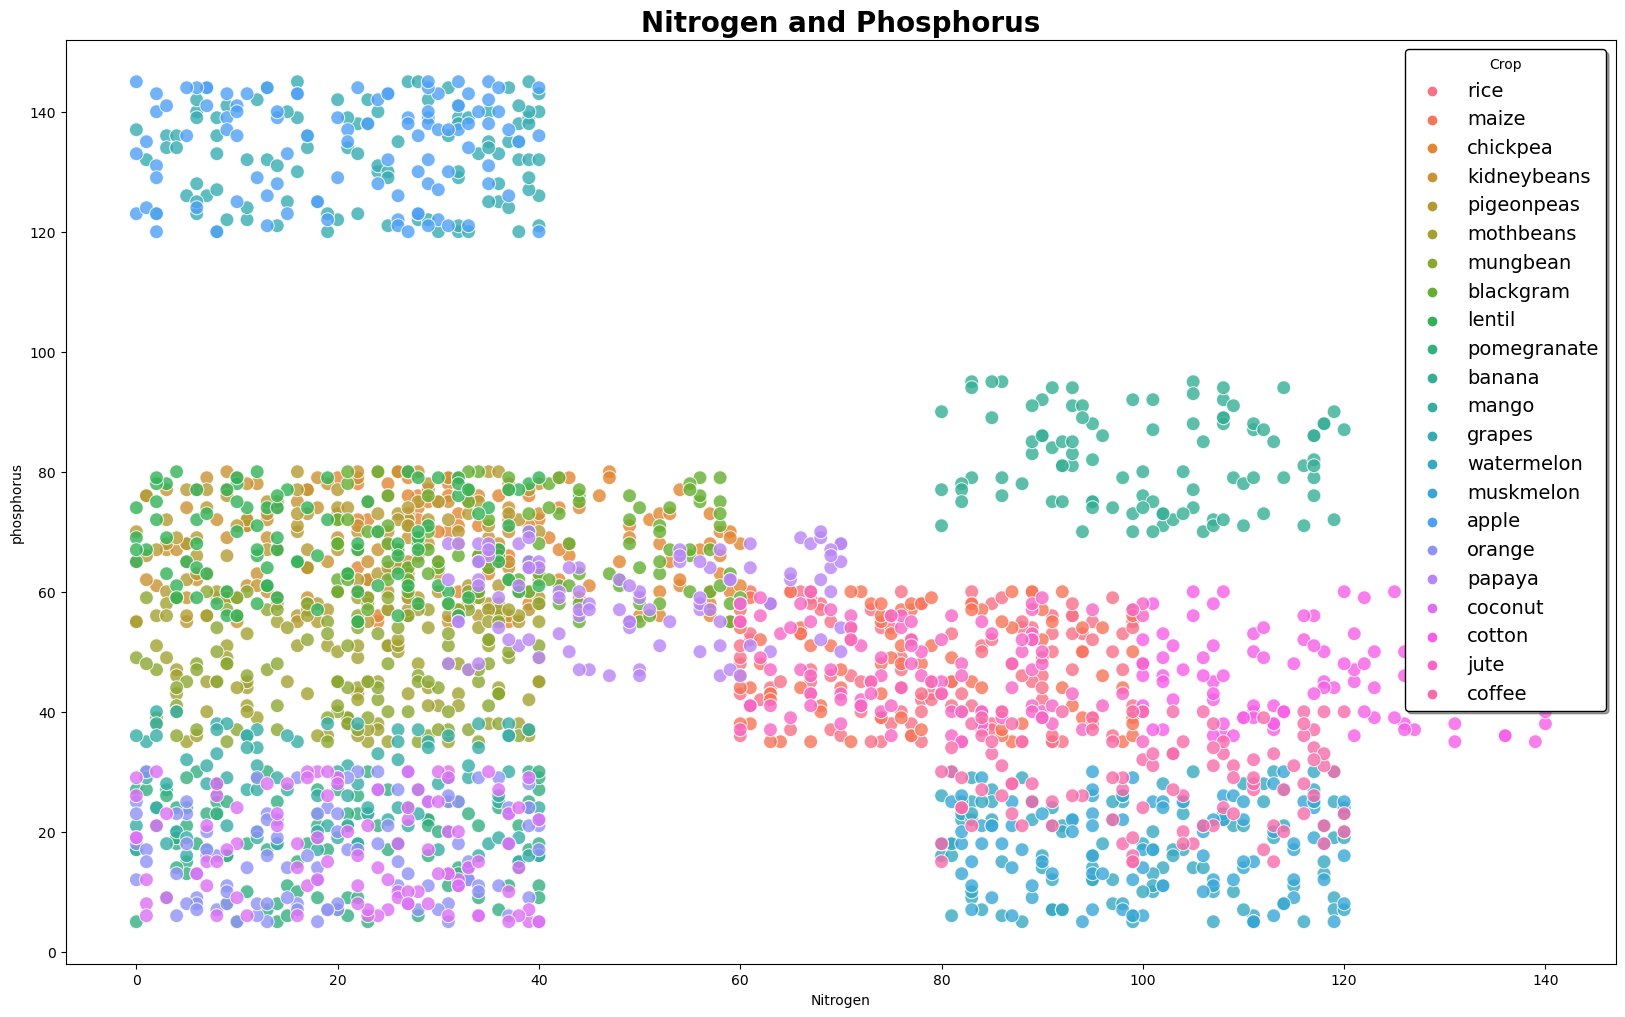

In [7]:
fig, ax = plt.subplots(figsize=(20, 12))

sns.scatterplot(x = "Nitrogen", y = "phosphorus", hue = "label", data = crop_rec_df, s = 100, alpha = 0.8)
ax.set_title("Nitrogen and Phosphorus", fontsize=20, fontweight = 'bold')
ax.legend(title = "Crop", fontsize = 14, loc = 'upper right', frameon = True, edgecolor = 'black', shadow = True)

plt.show()

### Part 2: Soil Data!

[Source.](https://ckan.publishing.service.gov.uk/dataset/soil_nutrient_balances_uk)

In [8]:
years = np.array([1990, 1995, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009])
nitrogen_balances = np.array([140.4, 123.0, 111.1, 113.1, 106.1, 100.0, 99.6, 95.2, 90.8, 92.0, 86.6, 85.6])
phos_balances = np.array([13.4, 13.4, 10.0, 10.6, 9.0, 9.6, 9.5, 9.1, 8.5, 8.4, 6.9, 4.3])

nitrogen_balances *= 0.1 # Normalize so both data are similarly scaled

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import cholesky
from scipy.spatial.distance import cdist
from IPython.display import clear_output
from time import sleep

def gaussian_sample(mu, Sigma):
    A = cholesky(Sigma)
    Z = np.random.normal(loc=0, scale=1, size=len(mu))
    return np.dot(A, Z) + mu

def mu_fun(x, mu=0):
    return mu * np.ones(len(x))

def K_fun(x, z, h=1):
    K = np.zeros(len(x)*len(z)).reshape(len(x), len(z))
    for j in np.arange(K.shape[1]):
        K[:,j] = (1/h)*np.exp(-(x-z[j])**2/(2*h**2))
    return K

def gp(years, data, kernel, mean, noise, bandwidth, event_name):
    Xtrain = years
    ftrain = data
    K = kernel(Xtrain, Xtrain)
    xs = np.linspace(min(years)-1, max(years)+10, 500)
    h = bandwidth
    K = kernel(Xtrain, Xtrain, h=h)
    Ks = kernel(Xtrain, xs, h=h)
    sigma2 = noise
    Kss = kernel(xs, xs, h=h) + sigma2 * np.eye(len(xs))
    Ki = np.linalg.inv(K + sigma2 * np.eye(len(Xtrain)))
    postMu = mean(xs, np.mean(data)) + Ks.T @ Ki @ (ftrain - mean(Xtrain, np.mean(data)))
    postCov = Kss - Ks.T @ Ki @ Ks

    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    S2 = np.diag(postCov)
    ax.fill_between(xs, postMu - 2*np.sqrt(S2), postMu + 2*np.sqrt(S2), 
                        step="pre", alpha=0.2, label='posterior 95% confidence')

    fs = gaussian_sample(postMu, postCov)
    ax.plot(xs, fs, c='r', linestyle='-', linewidth=.1)
    ax.plot(xs, postMu, c='black')
    ax.scatter(Xtrain, ftrain, color='red', marker='o', linewidth=.4)
    ax.set_xlabel('year', fontsize=14)
    _ = ax.set_ylabel(event_name, fontsize=14)
    

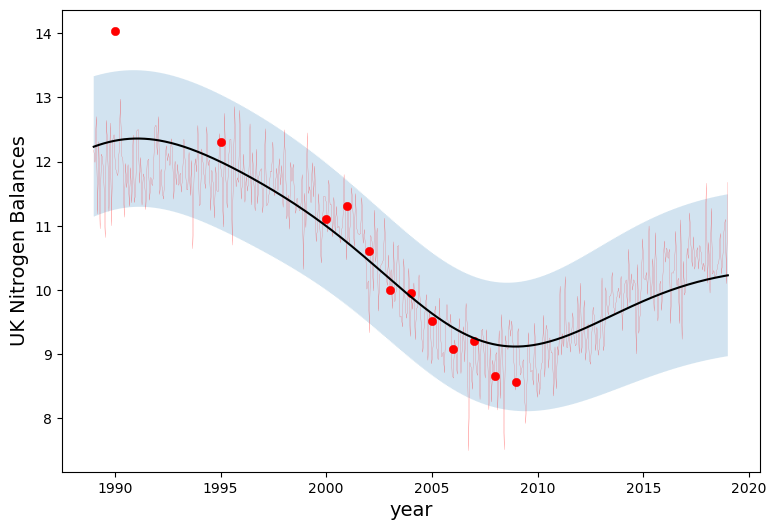

In [10]:
gp(years, nitrogen_balances, K_fun, mu_fun, 0.2, 5, "UK Nitrogen Balances")

We can use the wonderful WoSIS dataset, which contains a massive amount of information. It will require some tidying before use in our GPs - first, we can make the dates behave well.

In [11]:
nitrogen_df = pd.read_csv("data/wosis_latest_nitkjd.csv")
usa_nitrogen_df = nitrogen_df[nitrogen_df.country_name == "United States of America"]
usa_nitrogen_df.head()

c:\Users\mlisi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3203: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,X,Y,profile_id,profile_layer_id,country_name,upper_depth,lower_depth,layer_name,litter,nitkjd_value,nitkjd_value_avg,nitkjd_method,nitkjd_date,nitkjd_dataset_id,nitkjd_profile_code,nitkjd_licence
39301,-105.731110,37.155556,66207,599837,United States of America,0.0,5,A1,0.0,"{1:0.59,2:0.59}",0.59,"{""1:sample pretreatment = sieved over 2 mm sie...","{1:1979-8-3,2:1979-8-3}",US-NCSS,79P0366,U.S. Public Domain http://www.usa.gov/publicdo...
39302,-105.731110,37.155556,66207,599838,United States of America,5.0,10,A2,0.0,"{1:0.60,2:0.60}",0.60,"{""1:sample pretreatment = sieved over 2 mm sie...","{1:1979-8-3,2:1979-8-3}",US-NCSS,79P0366,U.S. Public Domain http://www.usa.gov/publicdo...
39303,-105.731110,37.155556,66207,599839,United States of America,10.0,28,B,0.0,"{1:1.46,2:1.46}",1.46,"{""1:sample pretreatment = sieved over 2 mm sie...","{1:1979-8-3,2:1979-8-3}",US-NCSS,79P0366,U.S. Public Domain http://www.usa.gov/publicdo...
39402,-103.995277,47.848888,66469,599965,United States of America,0.0,15,Ap,0.0,"{1:1.77,2:1.77}",1.77,"{""1:sample pretreatment = sieved over 2 mm sie...","{1:2005-3-1,2:2005-3-1}",US-NCSS,95P0284,U.S. Public Domain http://www.usa.gov/publicdo...
39403,-103.995277,47.848888,66469,599966,United States of America,15.0,31,NaN,0.0,"{1:1.49,2:1.49}",1.49,"{""1:sample pretreatment = sieved over 2 mm sie...","{1:2005-3-1,2:2005-3-1}",US-NCSS,95P0284,U.S. Public Domain http://www.usa.gov/publicdo...


In [12]:
from datetime import datetime
def str_to_date(s):
    '''
    s: a string of form {1:1979-8-3,2:1979-8-3}
    '''
    half_braceless = s.replace('{', '')
    braceless = half_braceless.replace('}', '')
    datestring = braceless.split(',')[0]
    datestring = datestring[2:]

    year, month, day = datestring.split('-')

    if year == '????':
        return 'NaN'
    
    if month == '??':
        return datetime.strptime(year, '%Y')
    
    if day == '??':
        return datetime.strptime(year+'-'+month, '%Y-%m')

    return datetime.strptime(datestring, '%Y-%m-%d')


def str_to_year(s):
    '''
    s: a string of form {1:1979-8-3,2:1979-8-3}
    '''
    half_braceless = s.replace('{', '')
    braceless = half_braceless.replace('}', '')
    datestring = braceless.split(',')[0]
    datestring = datestring[2:]

    year, month, day = datestring.split('-')

    if year == '????':
        return np.nan

    return int(year)

In [13]:
usa_nitrogen_df = nitrogen_df[nitrogen_df.country_name == "United States of America"]
usa_nitrogen_df['nitkjd_date'] = usa_nitrogen_df['nitkjd_date'].apply(str_to_year)
usa_nitrogen_df.sort_values(by=['nitkjd_date']).dropna()

C:\Users\mlisi\AppData\Local\Temp\ipykernel_12276\2457562411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_nitrogen_df['nitkjd_date'] = usa_nitrogen_df['nitkjd_date'].apply(str_to_year)


,X,Y,profile_id,profile_layer_id,country_name,upper_depth,lower_depth,layer_name,litter,nitkjd_value,nitkjd_value_avg,nitkjd_method,nitkjd_date,nitkjd_dataset_id,nitkjd_profile_code,nitkjd_licence
99413,-102.544746,48.864967,149819,673455,United States of America,122.0,183,C,0.0,"{1:0.30,2:0.30}",0.30,"{""1:sample pretreatment = sieved over 2 mm sie...",1949.0,US-NCSS,40A0023,U.S. Public Domain http://www.usa.gov/publicdo...
99412,-102.544746,48.864967,149819,673454,United States of America,91.0,122,Bk2,0.0,"{1:0.30,2:0.30}",0.30,"{""1:sample pretreatment = sieved over 2 mm sie...",1949.0,US-NCSS,40A0023,U.S. Public Domain http://www.usa.gov/publicdo...
99411,-102.544746,48.864967,149819,673453,United States of America,61.0,91,Bk1,0.0,"{1:0.34,2:0.34}",0.34,"{""1:sample pretreatment = sieved over 2 mm sie...",1949.0,US-NCSS,40A0023,U.S. Public Domain http://www.usa.gov/publicdo...
99410,-102.544746,48.864967,149819,673452,United States of America,41.0,61,Bw2,0.0,"{1:0.48,2:0.48}",0.48,"{""1:sample pretreatment = sieved over 2 mm sie...",1949.0,US-NCSS,40A0023,U.S. Public Domain http://www.usa.gov/publicdo...
99409,-102.544746,48.864967,149819,673451,United States of America,18.0,41,Bw1,0.0,"{1:1.22,2:1.22}",1.22,"{""1:sample pretreatment = sieved over 2 mm sie...",1949.0,US-NCSS,40A0023,U.S. Public Domain http://www.usa.gov/publicdo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99195,-83.876889,42.155417,149593,672057,United States of America,72.0,89,CB,0.0,"{1:0.24,2:0.24}",0.24,"{""1:sample pretreatment = sieved over 2 mm sie...",2014.0,US-NCSS,14N0315,U.S. Public Domain http://www.usa.gov/publicdo...
99192,-83.876889,42.155417,149593,672054,United States of America,36.0,48,Bt2,0.0,"{1:0.84,2:0.84}",0.84,"{""1:sample pretreatment = sieved over 2 mm sie...",2014.0,US-NCSS,14N0315,U.S. Public Domain http://www.usa.gov/publicdo...
99191,-83.876889,42.155417,149593,672053,United States of America,23.0,36,Bt1,0.0,"{1:0.70,2:0.70}",0.70,"{""1:sample pretreatment = sieved over 2 mm sie...",2014.0,US-NCSS,14N0315,U.S. Public Domain http://www.usa.gov/publicdo...
99198,-83.876889,42.155417,149593,672060,United States of America,127.0,152,C3,0.0,"{1:0.91,2:0.91}",0.91,"{""1:sample pretreatment = sieved over 2 mm sie...",2014.0,US-NCSS,14N0315,U.S. Public Domain http://www.usa.gov/publicdo...


We can then restrict our data to a specific region of the country - after all, the USA is big! We can take a box enclosing latitudes 36 to 39 and longitudes -103 to -100, which captures a chunk of one of the most agrarian parts of the country.

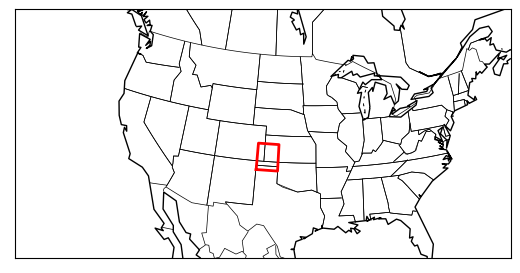

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Create a map of the United States
m = Basemap(llcrnrlon=-130, llcrnrlat=20, urcrnrlon=-60, urcrnrlat=50, projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

# Draw coastlines, states, and countries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Draw a rectangle around the specified latitudes and longitudes
lats = [36, 36, 39, 39, 36]
lons = [-103, -100, -100, -103, -103]
x, y = m(lons, lats)
m.plot(x, y, 'r-', linewidth=2)

# Show the plot
plt.show()


In [15]:
regional_nit_df = usa_nitrogen_df[(usa_nitrogen_df.X < -100) & (usa_nitrogen_df.X > -103) & (usa_nitrogen_df.Y < 39) & (usa_nitrogen_df.Y > 36)].dropna()
regional_nit_df

,X,Y,profile_id,profile_layer_id,country_name,upper_depth,lower_depth,layer_name,litter,nitkjd_value,nitkjd_value_avg,nitkjd_method,nitkjd_date,nitkjd_dataset_id,nitkjd_profile_code,nitkjd_licence
46566,-101.034125,37.410100,69404,604775,United States of America,0.0,10,Ap,0.0,"{1:0.79,2:0.79}",0.79,"{""1:sample pretreatment = sieved over 2 mm sie...",1989.0,US-NCSS,89P0727,U.S. Public Domain http://www.usa.gov/publicdo...
46567,-101.034125,37.410100,69404,604776,United States of America,10.0,22,Bw1,0.0,"{1:0.68,2:0.68}",0.68,"{""1:sample pretreatment = sieved over 2 mm sie...",1989.0,US-NCSS,89P0727,U.S. Public Domain http://www.usa.gov/publicdo...
46568,-101.034125,37.410100,69404,604777,United States of America,22.0,38,Bw2,0.0,"{1:0.72,2:0.72}",0.72,"{""1:sample pretreatment = sieved over 2 mm sie...",1989.0,US-NCSS,89P0727,U.S. Public Domain http://www.usa.gov/publicdo...
46569,-101.034125,37.410100,69404,604778,United States of America,38.0,69,Bk,0.0,"{1:0.45,2:0.45}",0.45,"{""1:sample pretreatment = sieved over 2 mm sie...",1989.0,US-NCSS,89P0727,U.S. Public Domain http://www.usa.gov/publicdo...
52585,-101.692139,37.362778,135715,605638,United States of America,0.0,13,Ap,0.0,"{1:2.19,2:2.19}",2.19,"{""1:sample pretreatment = sieved over 2 mm sie...",1999.0,US-NCSS,00P0073,U.S. Public Domain http://www.usa.gov/publicdo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138617,-100.398132,36.142643,178362,857709,United States of America,50.0,89,Bk2,0.0,"{1:0.77,2:0.77}",0.77,"{""1:sample pretreatment = sieved over 2 mm sie...",1998.0,US-NCSS,99P0023,U.S. Public Domain http://www.usa.gov/publicdo...
138618,-100.398132,36.142643,178362,857710,United States of America,89.0,108,Bk3,0.0,"{1:0.52,2:0.52}",0.52,"{""1:sample pretreatment = sieved over 2 mm sie...",1998.0,US-NCSS,99P0023,U.S. Public Domain http://www.usa.gov/publicdo...
138619,-100.393097,36.141331,178363,857714,United States of America,0.0,26,A,0.0,"{1:2.13,2:2.13}",2.13,"{""1:sample pretreatment = sieved over 2 mm sie...",1998.0,US-NCSS,99P0024,U.S. Public Domain http://www.usa.gov/publicdo...
138620,-100.393097,36.141331,178363,857715,United States of America,26.0,42,Bk,0.0,"{1:1.95,2:1.95}",1.95,"{""1:sample pretreatment = sieved over 2 mm sie...",1998.0,US-NCSS,99P0024,U.S. Public Domain http://www.usa.gov/publicdo...


In [16]:
regional_nit_df = regional_nit_df.sort_values(by=['nitkjd_date'])
nitrogen_vals = np.array(regional_nit_df.nitkjd_value_avg)
dates = np.array(regional_nit_df.dropna().nitkjd_date)

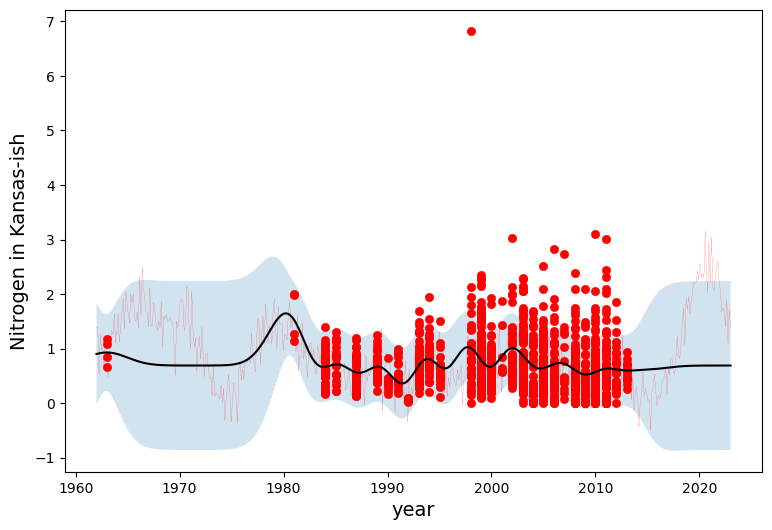

In [17]:
gp(dates, nitrogen_vals, K_fun, mu_fun, 0.1, 2, "Nitrogen in Kansas-ish")

In [18]:
phos = pd.read_csv("data/wosis_latest_phetb1.csv")
usa_phos_df = phos[phos.country_name == "United States of America"]
usa_phos_df['phetb1_date'] = usa_phos_df['phetb1_date'].apply(str_to_year)
usa_phos_df.sort_values(by=['phetb1_date']).dropna()

c:\Users\mlisi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3203: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\mlisi\AppData\Local\Temp\ipykernel_12276\2224134645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_phos_df['phetb1_date'] = usa_phos_df['phetb1_date'].apply(str_to_year)


,X,Y,profile_id,profile_layer_id,country_name,upper_depth,lower_depth,layer_name,litter,phetb1_value,phetb1_value_avg,phetb1_method,phetb1_date,phetb1_dataset_id,phetb1_profile_code,phetb1_licence
9402,-86.528038,36.901188,155142,713427,United States of America,0,13,Ap,0,"{1:9.00,2:9.00}",9.0,"{1:NULL,2:NULL}",1954.0,US-NCSS,54KY-227-010,U.S. Public Domain http://www.usa.gov/publicdo...
9406,-86.528038,36.901188,155142,713431,United States of America,163,213,Bt4,0,"{1:3.00,2:3.00}",3.0,"{1:NULL,2:NULL}",1954.0,US-NCSS,54KY-227-010,U.S. Public Domain http://www.usa.gov/publicdo...
9403,-86.528038,36.901188,155142,713428,United States of America,13,30,Bt1,0,"{1:1.00,2:1.00}",1.0,"{1:NULL,2:NULL}",1954.0,US-NCSS,54KY-227-010,U.S. Public Domain http://www.usa.gov/publicdo...
9404,-86.528038,36.901188,155142,713429,United States of America,30,74,Bt2,0,"{1:1.00,2:1.00}",1.0,"{1:NULL,2:NULL}",1954.0,US-NCSS,54KY-227-010,U.S. Public Domain http://www.usa.gov/publicdo...
9405,-86.528038,36.901188,155142,713430,United States of America,74,163,Bt3,0,"{1:1.00,2:1.00}",1.0,"{1:NULL,2:NULL}",1954.0,US-NCSS,54KY-227-010,U.S. Public Domain http://www.usa.gov/publicdo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12156,-94.436354,36.009775,156380,721110,United States of America,33,53,Bt2,0,"{1:17.00,2:17.00}",17.0,"{1:NULL,2:NULL}",2014.0,US-NCSS,65WS04,U.S. Public Domain http://www.usa.gov/publicdo...
2318,-72.827499,42.549446,138093,618059,United States of America,0,5,A1/A2,0,"{1:26.00,2:26.00}",26.0,"{1:NULL,2:NULL}",2014.0,US-NCSS,01P0090,U.S. Public Domain http://www.usa.gov/publicdo...
12575,-94.436150,36.148464,156681,723521,United States of America,0,13,A,0,"{1:42.00,2:42.00}",42.0,"{1:NULL,2:NULL}",2015.0,US-NCSS,68BN04,U.S. Public Domain http://www.usa.gov/publicdo...
12576,-94.436150,36.148464,156681,723522,United States of America,13,38,E,0,"{1:100.00,2:100.00}",100.0,"{1:NULL,2:NULL}",2015.0,US-NCSS,68BN04,U.S. Public Domain http://www.usa.gov/publicdo...


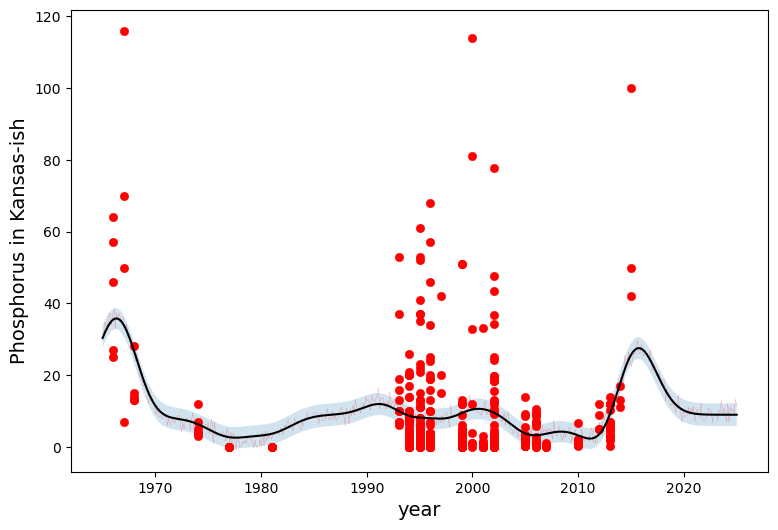

In [19]:
regional_phos_df = usa_phos_df[(usa_phos_df.X < -90) & (usa_phos_df.X > -100) & (usa_phos_df.Y < 39) & (usa_phos_df.Y > 36)].dropna()
regional_phos_df = regional_phos_df.sort_values(by=['phetb1_date'])
phos_vals = np.array(regional_phos_df.phetb1_value_avg)
dates = np.array(regional_phos_df.phetb1_date)

gp(dates, phos_vals, K_fun, mu_fun, 2, 2, "Phosphorus in Kansas-ish")

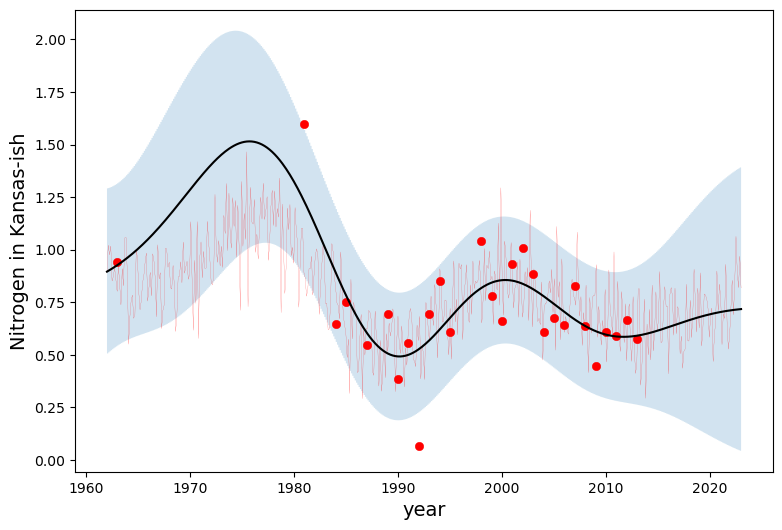

In [30]:
mean_nit_by_year = regional_nit_df.groupby("nitkjd_date")['nitkjd_value_avg'].mean()
avg_nits = np.array(mean_nit_by_year)
years = np.array(regional_nit_df['nitkjd_date'].unique())

gp(years, avg_nits, K_fun, mu_fun, 0.02, 8, "Nitrogen in Kansas-ish")

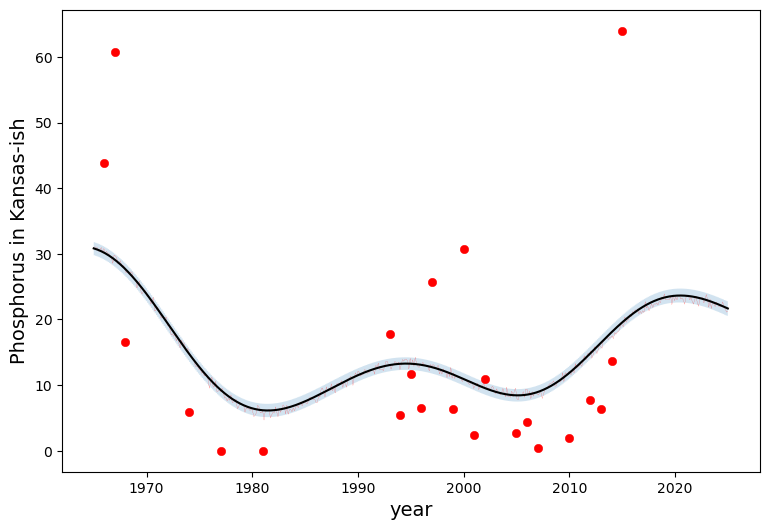

In [40]:
mean_p_by_year = regional_phos_df.groupby("phetb1_date")['phetb1_value_avg'].mean()
avg_ps = np.array(mean_p_by_year)
years = np.array(regional_phos_df['phetb1_date'].unique())

gp(years, avg_ps, K_fun, mu_fun, 0.2, 8, "Phosphorus in Kansas-ish")

### Part 3: K-means clusters 


c:\Users\mlisi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\mlisi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


AttributeError: 'PathCollection' object has no attribute 'set_title'

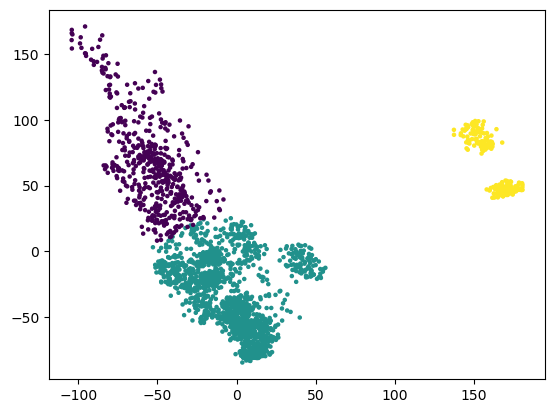

In [70]:
import pandas as pd
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Load the dataset into a Pandas dataframe
crop_rec_df = pd.read_csv("data/Crop_recommendation.csv")

# Remove any unnecessary columns
true_labels = crop_rec_df['label']
crop_rec_df = crop_rec_df.drop(columns=['label', 'Unnamed: 8', 'Unnamed: 9']).dropna()

# Convert the dataframe into a NumPy array
crop_rec_data = crop_rec_df.to_numpy()

# Specify the number of clusters you want to form
num_clusters = 3

# Create an instance of the KMeans class
kmeans = KMeans(n_clusters=num_clusters, max_iter = 1000)

# Fit the KMeans model to the data
kmeans.fit(crop_rec_data)

# Retrieve the labels for each data point and the centers of each cluster
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Apply PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
crop_rec_data_pca = pca.fit_transform(crop_rec_data)

# Add the reduced dimensions to the dataframe
crop_rec_df['PC1'] = crop_rec_data_pca[:,0]
crop_rec_df['PC2'] = crop_rec_data_pca[:,1]

# Add the labels as a new column in the dataframe
crop_rec_df['labels'] = labels
crop_rec_df['true_labels'] = true_labels


# Create a dictionary to map the true labels to integers
true_label_map = {'rice': 0, 'maize': 1, 'chickpea': 2, 'kidneybeans': 3, 'pigeonpeas': 4, 'mothbeans': 5, 'mungbean': 6, 
                  'blackgram': 7, 'lentil': 8, 'pomegranate': 9, 'banana': 10, 'mango': 11, 'grapes': 12, 'watermelon': 13,
                  'muskmelon': 14, 'apple': 15, 'orange': 16, 'papaya': 17, 'coconut': 18, 'coffee': 19, 'jute': 20, 'cotton': 21
                  }
crop_rec_df['true_labels_int'] = crop_rec_df['true_labels'].map(true_label_map)

import seaborn as sns
ax = plt.scatter(x=crop_rec_df['PC1'], y=crop_rec_df['PC2'], c=crop_rec_df['labels'], s=5)

ax.set_title('Crop K-Means Clustering with 3 clusters')

# Show the plot
plt.show()

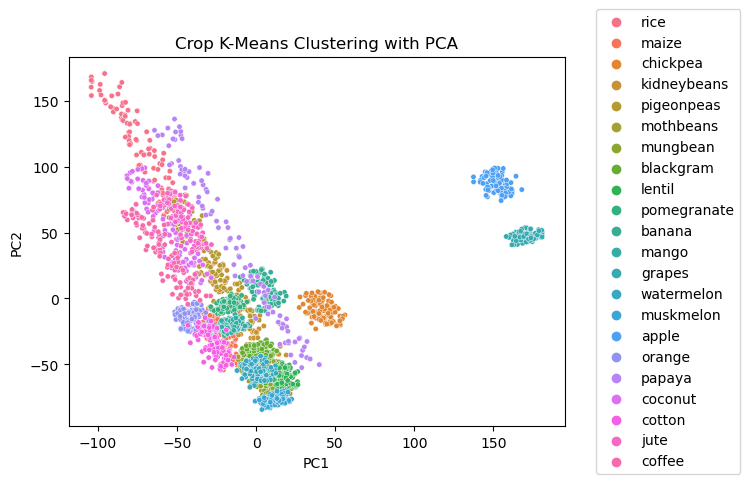

In [58]:
ax = sns.scatterplot(x=crop_rec_df['PC1'], y=crop_rec_df['PC2'], hue = crop_rec_df['true_labels'], s=15)


ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))


# Set the title of the main plot
ax.set_title('Crop K-Means Clustering with PCA')


# Show the plot
plt.show()